In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from matplotlib import colors as mplcolors

# build report
from reportlab.platypus.flowables import Flowable
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, ListFlowable, ListItem
from reportlab.lib.pagesizes import A4
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.colors import HexColor
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# border and row shading for tables
a_color = "saddlebrown"
table_row = "saddlebrown"

# a place to save figures and a 
# method to choose formats
save_fig_prefix = "resources/output/"

# the arguments for formatting the image
save_figure_kwargs = {
    "fname": None,
    "dpi": 300.0,
    "format": "jpeg",
    "bbox_inches": None,
    "pad_inches": 0,
    "bbox_inches": 'tight',
    "facecolor": 'auto',
    "edgecolor": 'auto',
    "backend": None,
}

## !! Begin Note book variables !!

# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/bielersee_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'bielersee', 'name':"Bielersee", 'level':'water_name_slug'}

# the lake is in this survey area
this_bassin = "aare"
# label for survey area
bassin_label = "Aare-Erhebungsgebiet"

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'city'

# identify the lakes of interest for the survey area
lakes_of_interest = ["bielersee"]    


# !! End note book variables !!
## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# !key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
fdx.codeGroupSummary()

# !this is the feature data!
fd = fdx.feature_data

# !keyword args to build period data
# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data. For a survey area
# or river bassin these_features = feature_parent and 
# feature_level = parent_level
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_bassin,
    "parent_level": "river_bassin",
    "period_name": bassin_label,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
# this can be done by updating the fd_kwargs
fd_rivers = fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()

# update the admin kwargs with river data to make the river summary
admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 14px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]


# pdf download is an option 
# reportlab is used to produce the document
# the arguments for the document are captured at run time
# capture for pdf content
pdf_link = f'/resources/pdfs/{this_feature["slug"]}.pdf'
pdfcomponents = []


# style definitions for pdf report
# section and paragraph formatting
# featuredata.title_style = ParagraphStyle(**{"name": "featuredata.title_style", "fontSize": 18, "fontName": "Helvetica"})
# featuredata.section_title = ParagraphStyle(**{"name": "featuredata.section_title", "fontSize": 16, "fontName": "Helvetica"})
# featuredata.caption_style = ParagraphStyle(**{"name": "featuredata.caption_style", "fontSize": 9, "fontName": "Times-Italic"})
# subfeaturedata.section_title = ParagraphStyle(**{"name": "sub_featuredata.section_title", "fontSize": 12, "fontName": "Helvetica"})
# featuredata.p_style = ParagraphStyle(**{"name": "content", "fontSize": 10, "fontName": "Times-Roman"})
# bold_block = ParagraphStyle(**{"name": "bold_block", "fontSize": 10, "fontName": "Times-Bold"})
# indented = ParagraphStyle(**{"name": "indented", "fontSize": 10, "fontName": "Times-Roman", "leftIndent":36})

# spacers 
# featuredata.larger_space = Spacer(1, .5*inch)
# featuredata.large_space = Spacer(1, .25*inch)
# featuredata.small_space = Spacer(1, .2*inch)
# smaller_space = Spacer(1, .15*inch)
# featuredata.smallest_space = Spacer(1, .12*inch)

# table definitions:
# table_header = ParagraphStyle(**{"name": "table_header", "fontSize": 8, "fontName": "Helvetica", "alignment":1})
# table_style = ParagraphStyle(**{"name": "table_style", "fontSize": 8, "fontName": "Helvetica"})
# styled_table_header = ParagraphStyle(**{"name": "table_header", "fontSize": 8, "fontName": "Helvetica", "alignment":1})
# table_style_centered = ParagraphStyle(**{"name": "table_style", "fontSize": 8, "fontName": "Helvetica", "alignment":1})
# table_style_right = ParagraphStyle(**{"name": "table_style", "fontSize": 8, "fontName": "Helvetica", "alignment":2})

# def featuredata.addToDoc(flowables, alist):
    
#     doc_components = [*alist, *flowables]
#     return doc_components


# def adminFormatNumericInteger(func=featuredata.thousandsSeparator, an_int: str=None, language: str=None):
#     # uses the method defined by func to apply numeric formatting according to the language variable
#     try:
#         data = func(an_int, language)
#     except OSError as err:
#         print("The function provided did not work", err)
#         raise
#     else:
#         return data


# def stringStartEndDate(func=featuredata.dateToYearAndMonth, date_format: str="%Y-%m-%d", lang: str = "de",  a_date: str=None,):
#     # uses the method defined by func to apply date formatting according to the language variable
    
#     try:
#         data = func(datetime.strptime(a_date, date_format), lang=lang)
#     except (TypeError, OSError) as err:
#         print("Is the date formatted the same as the date_format? Are you sure of the method provided?", err)
    
#     else:
#         return data


# def makeAdminSummaryStateMent(start, end, feature_name, language: str="de", admin_summary: dict=None):
#     # the admin summary can be called from the admin class. It has a specific construction. 
#     # use the data in the admin summary class to assemble string representation
    
#     start_date = stringStartEndDate(a_date=start)
#     end_date = stringStartEndDate(a_date=end)
#     n_samples = adminFormatNumericInteger(an_int=admin_summary["loc_date"])
#     total = adminFormatNumericInteger(an_int=admin_summary["quantity"])
#     population = adminFormatNumericInteger(an_int=admin_summary["population"])
    
#     if language != None:
#         phrase_one = f"Im Zeitraum von {start_date}  bis {end_date} wurden im Rahmen von {n_samples} Datenerhebungen insgesamt {total} Objekte entfernt und identifiziert."
#         phrase_two = f"Die Ergebnisse des {feature_name} umfassen {admin_summary['location']} Orte, {admin_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {population} Einwohnenden."
        
#         return f'{phrase_one} {phrase_two}'
#     else:
#         return 'Check the language variable'
    
# def collectComponentLandMarks(admin_details, language="de"):
#     # the column headers are dependent on the language.
#     # using the admin_details class identify the component
#     # features of interest and have a language appropriate
#     # label.
    
#     component_list = []
    
#     if len(admin_details.lakesOfInterest()) > 0:
        
#         if language == "de":
#             header = "Seen"
        
#         if language == "fr":
#             header = "Lacs"
        
#         else:
#             header = "Lakes"
        
#         components = (header,  ", ".join(admin_details.lakes_of_interest))
        
#         component_list.append(components)
        
    
#     if len(admin_details.riversOfInterest()) > 0:
#         if language == "de":
#             header = "Fliessgewässer"
        
#         if language == "fr":
#             header = "Cours d'eaux"
        
#         else:
#             header = "Rivers"
        
#         components = (header,  ", ".join(admin_details.lakes_of_interest))
        
#         component_list.append(components)
        
#     if language == "de":
#             city_header = "Gemeinden"
        
#     if language == "fr":
#         city_header = "Communes"
        
#     else:
#         city_header = "Municipalities"
        
#     munis = (city_header, ", ".join(sorted(admin_details.populationKeys()["city"])))
       
    
#     component_list.append(munis)
    
#     return component_list
    
# class verticalText(Flowable):

#     '''Rotates a text in a table cell.'''

#     def __init__(self, text):
#         Flowable.__init__(self)
#         self.text = text

#     def draw(self):
#         canvas = self.canv
#         canvas.rotate(90)
#         fs = canvas._fontsize
#         canvas.translate(1, -fs/1.2)  # canvas._leading?
#         canvas.drawString(0, 0, self.text)

#     def wrap(self, aW, aH):
#         canv = self.canv
#         fn, fs = canv._fontname, canv._fontsize
#         return canv._leading, 1 + canv.stringWidth(self.text, fn, fs)
    
# def aStyledTable(data, header_style: Paragraph=styled_table_header, vertical_header: bool = False, data_style: Paragraph=table_style_centered, colWidths: []=None, style: []= None):
    
#     if vertical_header:
#         headers = [verticalText(x) for x in data.columns[1:]]
#         headers = [verticalText(" "), *headers]
#     else:
#         headers = [Paragraph(str(x), header_style)  for x in data.columns[1:]]
#         headers = [Paragraph(" ", table_style_centered) , *headers]
    
#     if style is None:
#         style=[
#         ('FONTNAME', (0,0), (-1,0), 'Helvetica'),
#         ('LINEBELOW',(0,0), (-1,0), 1, HexColor("#000")),
#         ('INNERGRID', (1,1), (-1,-1), 0.25, HexColor("#8b451330", hasAlpha=True)),
#         ('ROWBACKGROUNDS', (1,1), (-1,-1), [HexColor("#8b451320", hasAlpha=True), colors.white])
#         ]
    
#     new_rows = []
#     for a_row in data.values.tolist():
        
#         row_index = Paragraph(a_row[0], table_style_right)
#         row_data = [Paragraph(str(x), data_style) for x in a_row[1:]]
#         new_row = [row_index, *row_data]
#         new_rows.append(new_row)
        
#     new_table = [headers, *new_rows]
    
#     return Table(new_table, style=style, colWidths=colWidths, repeatRows=1)

# def colorGradient(x, cmap: str="YlOrBr", amin: int=0, amax: int=1):
#     a_cmap = plt.cm.get_cmap(cmap)
#     norm = mpl.colors.Normalize(vmin=amin, vmax=amax)
#     color = a_cmap(norm(x))
#     hex_color = mpl.colors.rgb2hex(color, keep_alpha=False)
    
#     return hex_color

# def stringifyValue(x):
#     if isinstance(x, str):
#         return x
#     else:
#         return str(x)
    
# def colorGradientTable(data, color_gradient: callable=colorGradient, column: int=None):
    
#     gradient_cells = TableStyle()
    
#     if column is None:
#         a_min = data.min().min()
#         a_max = data.max().max()
#         for i, row in enumerate(data.values):
#             for j, element in enumerate(row):
#                 hex_color = colorGradient(element, amin=a_min, amax=a_max)
#                 gradient_cells.add('BACKGROUND', (j+1, i+1), (j+1, i+1), hex_color)
    
#     elif isinstance(column, int) and column < len(data.values[0]):
#         for i, row in enumerate(data.values):
#             hex_color = colorGradient(row[column])
#             gradient_cells.add('BACKGROUND', (column+1,i+1), (column+1,i+1), hex_color)
#     else:
#         print("ouch")
    
#     return gradient_cells

# def featuredata.rotateText(x):
#     return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'
    

# pdf title and map
pdf_title = Paragraph(this_feature["name"], featuredata.title_style)
map_image =  Image(bassin_map, width=inch*7, height=inch*5, kind="proportional", hAlign= "LEFT")

pdfcomponents = featuredata.addToDoc([
    pdf_title,    
    featuredata.small_space,
    map_image
], pdfcomponents)

glue("feauture_name", this_feature["name"], display=False)
glue("pdf_link", pdf_link, display=False)

'Bielersee'

'/resources/pdfs/bielersee.pdf'

(bielersee_de)=
# Bielersee


{Download}`Download </resources/pdfs/bielersee.pdf>`

In [2]:
class Caption:
    
    position=''
    figure_number=0
    captions=[]
    start_caption = ""
    end_caption = '*'
    paragraphs = []
    
    def buildCaption(self):
        start_caption = f'*__{self.position}:__'
        new_string=''
        for line in self.captions:
            new_string += line
        end_caption = self.end_caption
        
        return f'{start_caption} {new_string}{end_caption}'
    
    def buildParagraph(self):
        new_string=''
        for line in self.paragraphs:
            new_string += line
        
        return new_string
        
            
map_caption = Caption()
map_caption.position = "Unten"
map_caption.captions = [
    "Karte des Erhebungsgebiets März 2020 bis Mai 2021. ",
    "Der Durchmesser der Punktsymbole entspricht dem Median der",
    "Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort."
]

# pdf output
map_caption.paragraphs = map_caption.captions
a_paragraph = map_caption.buildParagraph()

# add those sections
pdfcomponents = featuredata.addToDoc([Paragraph(a_paragraph, featuredata.caption_style)], pdfcomponents)


```{figure} resources/maps/bielersee_scaled.jpeg
---
name: bielersee_map
---
` `
```
{numref}`Abbildung %s: <bielersee_map>` Karte des Erhebungsgebiets März 2020 bis Mai 2021.  Der Durchmesser der Punktsymbole entspricht dem Median der Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort.

## Erhebungsorte

In [3]:

an_admin_summary = featuredata.makeAdminSummaryStateMent(start_date, end_date, this_feature["name"], admin_summary=admin_summary)
                      
# collect component features and land marks
feature_components = featuredata.collectComponentLandMarks(admin_details, language="de")

# markdown output
components_markdown = [f'*{x[0]}*\n\n>{x[1]}\n\n' for x in feature_components]

# add the admin summary to the pdf
pdfcomponents = featuredata.addToDoc([
    featuredata.large_space,
    Paragraph("Erhebungsorte", featuredata.section_title), 
    featuredata.small_space,
    Paragraph(an_admin_summary , featuredata.p_style),
    
    
], pdfcomponents)

# put that all together:
lake_string = F"""
{an_admin_summary}

{"".join(components_markdown)}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 38 Datenerhebungen insgesamt 4,477 Objekte entfernt und identifiziert. Die Ergebnisse des Bielersee umfassen 10 Orte, 8 Gemeinden und eine Gesamtbevölkerung von etwa 70,810 Einwohnenden.

*Lakes*

>Bielersee

*Municipalities*

>Biel/Bienne, Erlach, Gals, Le Landeron, Ligerz, Lüscherz, Nidau, Vinelz




### Kumulative Gesamtmengen nach Gemeinden

In [4]:
# add section to pdf
pdfcomponents = featuredata.addToDoc([featuredata.large_space, Paragraph("Kumulative Gesamtmengen nach Gemeinden", featuredata.section_title)], pdfcomponents)

# the .pdf output is generated in parallel
# this is the same as if it were on the backend where we would
# have a specific api endpoint for .pdf requests. 
dims_table = admin_details.dimensionalSummary()
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)

# apply language
dims_table.rename(columns=featuredata.dims_table_columns_de, inplace=True)

# convert to kilos
dims_table["Plastik (Kg)"] = dims_table["Plastik (Kg)"]/1000

# save a copyt of the dims_table for working
# formattinr to pdf will turn the numerics to strings
# which eliminates any further calclations
dims_df =  dims_table.copy()

# these columns need formatting for locale
thousands_separated = ["Fläche (m2)", "Länge (m)", "Erhebungen", "Objekte (St.)"]
replace_decimal = ["Plastik (Kg)", "Gesamtgewicht (Kg)"]

# format the dimensional summary for .pdf and add to components
dims_table[thousands_separated] = dims_table[thousands_separated].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
dims_table[replace_decimal] = dims_table[replace_decimal].applymap(lambda x: featuredata.replaceDecimal(str(round(x,2))))
dims_table.reset_index(inplace=True)

# a caption for the figure
dims_table_caption = f'{this_feature["name"]}: kumulierten Gewichte  und Masse für die Gemeinden'

# pdf components                 
d_chart = featuredata.aStyledTable(dims_table, colWidths=[1.2*inch] + [1.2*inch] + [None]*len(dims_table.columns))
d_capt = Paragraph(dims_table_caption, featuredata.caption_style)
pdfcomponents = featuredata.addToDoc([featuredata.small_space, d_chart, featuredata.smallest_space, d_capt, PageBreak()], pdfcomponents)

# this formats the table through the data frame
dims_df["Plastik (Kg)"] = dims_df["Plastik (Kg)"].round(2)
dims_df["Gesamtgewicht (Kg)"] = dims_df["Gesamtgewicht (Kg)"].round(2)
dims_df[thousands_separated] = dims_df[thousands_separated].astype("int")

# set the index name to None so it doesn't show in the columns
dims_df.index.name = None
dims_df.columns.name = None

# this applies formatting to the specifc column based on
# the language.
dims_table_formatter = {
    "Plastik (Kg)": lambda x: featuredata.replaceDecimal(x, "de"),
    "Gesamtgewicht (Kg)": lambda x: featuredata.replaceDecimal(x, "de"),
    "Fläche (m2)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Länge (m)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Erhebungen": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de")
}

# use the caption from the .pdf for the online figure
glue("bielersee_dims_table_caption",dims_table_caption, display=False)

# apply formatting and styles to dataframe
q = dims_df.style.format(formatter=dims_table_formatter).set_table_styles(table_css_styles)

# capture the figure before display and give it a reference number and caption
figure_name='bielersee_dims_table'
glue(figure_name, q, display=False)

'Bielersee: kumulierten Gewichte  und Masse für die Gemeinden'

,Gesamtgewicht (Kg),Plastik (Kg),Fläche (m2),Länge (m),Erhebungen,Objekte (St.)
Bielersee,"13,1","6,67",6 343,1 247,38,4 477
Biel/Bienne,"7,34","3,69",4 584,580,14,2 969
Vinelz,"3,1","1,86",536,238,12,898
Lüscherz,"1,72","0,33",538,257,5,202
Ligerz,"0,3","0,29",49,15,2,143
Erlach,"0,05","0,05",374,57,1,101
Nidau,"0,13","0,0",105,25,1,63
Le Landeron,"0,04","0,04",93,37,1,53
Gals,"0,43","0,4",64,38,2,48


```{glue:figure} bielersee_dims_table
---
name: 'bielersee_dims_table'
---
` `
```
{numref}`Abbildung %s: <bielersee_dims_table>` {glue:text}`bielersee_dims_table_caption`

### Verteilung der Erhebungsergebnisse

'Links: Bielersee, März 2020 bis Mai 2021, n = 38. Rechts: empirische Verteilungsfunktion der Erhebungsergebnisse Bielersee.'

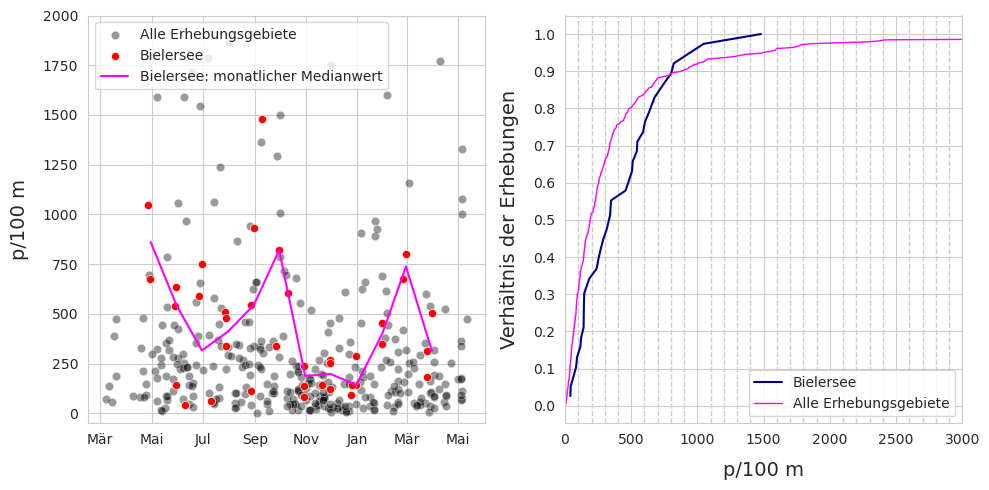

In [5]:
# figure caption
sample_total_notes = f'Links: {this_feature["name"]}, {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)} bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang=date_lang)}, n = {admin_summary["loc_date"]}. Rechts: empirische Verteilungsfunktion der Erhebungsergebnisse {this_feature["name"]}.'
glue("sample_total_notes", sample_total_notes, display=False)

dx = period_data.parentSampleTotals(parent=False)

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# get the monthly or quarterly results for the feature
rsmp = fdx.sample_totals.set_index("date")
resample_plot, rate = featuredata.quarterlyOrMonthlyValues(rsmp, this_feature["name"], vals=unit_label)

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dx, x="date", y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fdx.sample_totals, x="date", y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)
# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)
# axis formatting
ax.set_ylabel(unit_label, **ck.xlab_k14)
ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.set_ylim(-50, 2000)
# call the legend
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = featuredata.ecdfOfAColumn(fdx.sample_totals, unit_label)    
sns.lineplot(x=feature_ecd["x"], y=feature_ecd["y"], color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = featuredata.ecdfOfAColumn(dx, unit_label)
sns.lineplot(x=other_features["x"], y=other_features["y"], color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)
axtwo.set_xlim(0, 3000)

axtwo.xaxis.set_major_locator(MultipleLocator(500))
axtwo.xaxis.set_minor_locator(MultipleLocator(100))
axtwo.yaxis.set_major_locator(MultipleLocator(.1))
axtwo.grid(which="minor", visible=True, axis="x", linestyle="--", linewidth=1)

figure_name = "bielersee_sample_totals"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})

plt.tight_layout()
plt.savefig(**save_figure_kwargs)
glue("bielersee_sample_totals", fig, display=False)
plt.close()

```{glue:figure} bielersee_sample_totals
---
name: 'bielersee_sample_totals'
---
` `
```
{numref}`Abbildung %s: <bielersee_sample_totals>` {glue:text}`sample_total_notes`

### Zusammengefasste Daten und Materialarten

In [6]:
# figure caption
summary_of_survey_totals = f'Zusammenfassung der Daten aller Erhebungen am {this_feature["name"]}. Gefundene Materialarten am {this_feature["name"]} in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).'

'Zusammenfassung der Daten aller Erhebungen am Bielersee. Gefundene Materialarten am Bielersee in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).'

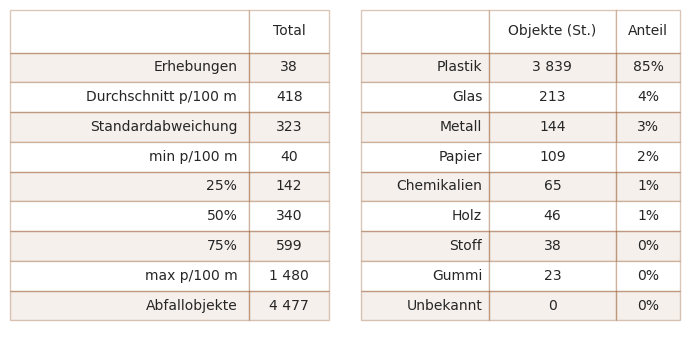

In [7]:
# add to pdf
s_totals = Image(sample_totals_file_name, width=inch*6, height=inch*4.8, kind="proportional", hAlign= "LEFT")
s_totals_caption = Paragraph(sample_total_notes, featuredata.caption_style)
pdfcomponents = featuredata.addToDoc([Paragraph("Verteilung der Erhebungsergebnisse", featuredata.subsection_title), featuredata.small_space, s_totals, s_totals_caption], pdfcomponents)

csx = fdx.sample_summary.copy()

combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]

# the materials table
fd_mat_totals = fdx.material_summary.copy()
fd_mat_totals = featuredata.fmtPctOfTotal(fd_mat_totals, around=0)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Objekte (St.)", "% of total":"Anteil"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], featuredata.thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2, figsize=(7, len(combined_summary)*.4))

# summary table
# names for the table columns
a_col = [this_feature["name"], "Total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(10)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .4,.2],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(10)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.margins(0, 0)
figure_name = "bielersee_sample_summaries"
sample_summaries_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_summaries_file_name})

plt.savefig(**save_figure_kwargs)


glue('summary_of_survey_totals', summary_of_survey_totals, display=False)


glue(figure_name, fig, display=False)
plt.close()

```{glue:figure} bielersee_sample_summaries
---
name: 'bielersee_sample_summaries'
---
` `
```
{numref}`Abbildung %s: <bielersee_sample_summaries>` {glue:text}`summary_of_survey_totals`

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate)

In [8]:
# add summary tables to pdf
samp_mat_subsection = Paragraph("Zusammengefasste Daten und Materialarten", featuredata.subsection_title)
samp_material_table = Image(sample_summaries_file_name , width=inch*6, height=inch*4.8, kind="proportional", hAlign= "LEFT")
samp_material_caption = Paragraph(summary_of_survey_totals, featuredata.caption_style)

new_components = [
    featuredata.large_space,
    samp_mat_subsection,
    featuredata.small_space,
    samp_material_table,
    samp_material_caption,
    PageBreak() 
]

pdfcomponents = featuredata.addToDoc([featuredata.large_space, samp_mat_subsection, featuredata.small_space, samp_material_table, samp_material_caption, PageBreak() ], pdfcomponents)

# the most common results
most_common_display = fdx.most_common

# language appropriate columns
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})

# data for display
most_common_display.rename(columns=cols_to_use, inplace=True)
most_common_display = most_common_display[cols_to_use.values()].copy()
most_common_display = most_common_display.set_index("Objekt", drop=True)

# .pdf output
data = most_common_display.copy()
data["Anteil"] = data["Anteil"].map(lambda x: f"{int(x)}%")
data['Objekte (St.)'] = data['Objekte (St.)'].map(lambda x:featuredata.thousandsSeparator(x, language))
data["fail rate"] = data['Häufigkeitsrate'].map(lambda x: f"{x}%")
data[unit_label] = data[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

pdf_mc_table  = featuredata.aStyledTable(data.reset_index(), colWidths=[2.3*inch] + [None]*len(data.columns))

# get percent of total to make the caption string
m_common_percent_of_total = fdx.most_common['Objekte (St.)'].sum()/fdx.code_summary['quantity'].sum()

mc_caption_string = [
    f'Häufigste Objekte im {this_feature["name"]}: ',
    'd. h. Objekte mit einer Häufigkeitsrate von mindestens 50% und/oder ',
    f'Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% ',
    f'aller gefundenen Objekte aus. Anmerkung: {unit_label} = Medianwert der Erhebung.'
]

mc_caption_string = "".join(mc_caption_string)

most_common_display.index.name = None
most_common_display.columns.name = None

# set pandas display
aformatter = {
    "Anteil":lambda x: f"{int(x)}%",
    f"{unit_label}": lambda x: featuredata.replaceDecimal(x, "de"),
    "Häufigkeitsrate": lambda x: f"{int(x)}%",   
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de")
}

mcd = most_common_display.style.format(aformatter).set_table_styles(table_css_styles)
glue('bielersee_most_common_caption', mc_caption_string, display=False)
glue('bielersee_most_common_tables', mcd, display=False)

'Häufigste Objekte im Bielersee: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50% und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte 73% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.'

,Objekte (St.),Anteil,Häufigkeitsrate,p/100 m
Fragmentierte Kunststoffe,746,16%,97%,"53,0"
Zigarettenfilter,744,16%,78%,"9,0"
Snack-Verpackungen,325,7%,86%,"21,0"
Industriefolie (Kunststoff),300,6%,89%,"18,0"
"Getränke Glasflasche, Stücke",176,3%,68%,"5,5"
Expandiertes Polystyrol,173,3%,63%,"5,5"
"Verpackungsfolien, nicht für Lebensmittel",173,3%,63%,"9,5"
"Tabak; Kunststoffverpackungen, Behälter",92,2%,73%,"5,5"
Schaumstoff EVA (flexibler Kunststoff),92,2%,31%,"0,0"
Kunststoff-Bauabfälle,89,1%,71%,"4,5"


```{glue:figure} bielersee_most_common_tables
---
name: 'bielersee_most_common_tables'
---
` `
```
{numref}`Abbildung %s: <bielersee_most_common_tables>` {glue:text}`bielersee_most_common_caption`

### Die am häufigsten gefundenen Objekte nach Gemeinden

In [9]:
# add new section to pdf
mc_section_title = Paragraph("Die am häufigsten gefundenen Objekte", featuredata.section_title)
para_g = "Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate)"
mc_section_para = Paragraph(para_g, featuredata.p_style)
mc_table_cap = Paragraph(mc_caption_string, featuredata.caption_style)
mc_heatmap_title = Paragraph("Die am häufigsten gefundenen Objekte nach Gemeinden", featuredata.subsection_title)


new_components = [
    mc_section_title,
    featuredata.small_space,
    mc_section_para,
    featuredata.large_space,
    pdf_mc_table,
    featuredata.smallest_space,
    mc_table_cap,
    featuredata.small_space,    
    mc_heatmap_title,
    featuredata.large_space
]
pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

mc_heat_map_caption = f'Median {unit_label} der häufigsten Objekte am {this_feature["name"]}.'

# calling componentsMostCommon gets the results for the most common codes
# at the component level
components = fdx.componentMostCommonPcsM()

# pivot that and quash the hierarchal column index that is created when the table is pivoted
mc_comp = components[["item", unit_label, "city"]].pivot(columns="city", index="item")
mc_comp.columns = mc_comp.columns.get_level_values(1)

# the aggregated total of the feature is taken from the most common objects table
mc_feature = fdx.most_common[unit_label]
mc_feature = featuredata.changeSeriesIndexLabels(mc_feature, {x:fdx.dMap.loc[x] for x in mc_feature.index})

# aggregated totals of the parent this is derived from the arguments in kwargs
mc_parent = period_data.parentMostCommon(parent=True)
mc_parent = featuredata.changeSeriesIndexLabels(mc_parent, {x:fdx.dMap.loc[x] for x in mc_parent.index})

# the aggregated totals of all the period data
mc_period = period_data.parentMostCommon(parent=False)
mc_period = featuredata.changeSeriesIndexLabels(mc_period, {x:fdx.dMap.loc[x] for x in mc_period.index})

# add the feature, bassin_label and period results to the components table
mc_comp[this_feature["name"]]= mc_feature
mc_comp[bassin_label] = mc_parent
mc_comp[top] = mc_period

# pdf out put
heat_map_caption = Paragraph(mc_heat_map_caption, featuredata.caption_style)
heat_map_gradient = featuredata.colorGradientTable(mc_comp)

mc_heat_map  = featuredata.aStyledTable(mc_comp.reset_index(), vertical_header=True, colWidths=[2.3*inch] + [None]*len(mc_comp.columns))
heat_map_gradient = featuredata.colorGradientTable(mc_comp)
mc_heat_map.setStyle(heat_map_gradient)
# pdfcomponents = featuredata.addToDoc(mc_heat_map, pdfcomponents)
# mc_heat_map.setStyle(heat_map_gradient)
new_components = [
    mc_heat_map,
    featuredata.smallest_space,
    heat_map_caption,
    featuredata.large_space,
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

# notebook display style
aformatter = {x: featuredata.replaceDecimal for x in mc_comp.columns}
mcd = mc_comp.style.format(aformatter).set_table_styles(table_css_styles)
mcd = mcd.background_gradient(axis=None, vmin=mc_comp.min().min(), vmax=mc_comp.max().max(), cmap="YlOrBr")

# remove the index name and column name labels
mcd.index.name = None
mcd.columns.name = None

# rotate the text on the header row
# the .applymap_index method in the
# df.styler module is used for this
mcd = mcd.applymap_index(featuredata.rotateText, axis=1)

# display markdown html
glue('mc_heat_map_caption', mc_heat_map_caption, display=False)

glue('bielersee_most_common_heat_map', mcd, display=False)

'Median p/100 m der häufigsten Objekte am Bielersee.'

,Biel/Bienne,Erlach,Gals,Le Landeron,Ligerz,Lüscherz,Nidau,Vinelz,Bielersee,Aare-Erhebungsgebiet,Alle Erhebungsgebiete
Expandiertes Polystyrol,"19,0","2,0","0,0","8,0","6,0","0,0","4,0","0,0","5,5","4,0","5,0"
Feuerwerkskörper; Raketenkappen,"2,0","9,0","0,0","5,0","12,5","0,0","0,0","8,0","4,0","0,0","0,0"
Fragmentierte Kunststoffe,"50,5","49,0","28,5","22,0","193,5","14,0","64,0","128,0","53,0","18,5","18,0"
"Getränke Glasflasche, Stücke","2,5","2,0","7,5","0,0","100,0","20,0","12,0","8,5","5,5","3,0","3,0"
Industriefolie (Kunststoff),"20,5","0,0","2,5","19,0","119,0","5,0","40,0","37,0","18,0","5,0","5,0"
Industriepellets (Nurdles),"4,5","0,0","0,0","0,0","0,0","0,0","8,0","10,5","2,5","0,0","0,0"
Kunststoff-Bauabfälle,"7,0","2,0","0,0","3,0","0,0","0,0","4,0","7,0","4,5","0,0","1,0"
Schaumstoff EVA (flexibler Kunststoff),"1,0","0,0","2,5","0,0","7,0","0,0","0,0","0,0","0,0","0,0","0,0"
Schaumstoffverpackungen/Isolierung,"7,5","0,0","0,0","0,0","21,5","0,0","0,0","0,0","1,0","0,0","1,0"
Snack-Verpackungen,"41,5","5,0","12,5","27,0","78,5","2,0","60,0","18,5","21,0","8,0","9,0"


```{glue:figure} bielersee_most_common_heat_map
---
name: 'bielersee_most_common_heat_map'
---
` `
```

{numref}`Abbildung %s: <bielersee_most_common_heat_map>` {glue:text}`mc_heat_map_caption`

### Die am häufigsten gefundenen Objekte im monatlichen Durchschnitt

In [10]:
# collect the survey results of the most common objects
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# collect the code data for the most common codes
m_common_m = fd[(fd.code.isin(fdx.most_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)

# get the total per code and set the order of the
# index by quantity
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# collect the monthly results for each code
# into a dict, key = description
mgr = {}
for a_group in an_order:
    # resample by month
    a_cell = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_cell}
    mgr.update(this_group)

# make df and collect the abbreviated month name
# set that to index
by_month = pd.DataFrame.from_dict(mgr)
by_month["month"] = by_month.index.map(lambda x: get_month_names('abbreviated', locale=date_lang)[x.month])
by_month.set_index('month', drop=True, inplace=True)

# transpose to get months on the columns
mcdm = by_month.T
mcdm = mcdm.astype("int")
mcdm["Objekt"] = mcdm.index.map(lambda x: fdx.dMap.loc[x])
mcdm.set_index("Objekt", drop=True, inplace=True)
mcdm.index.name = None
mcdm.columns.name = None
mcdm = mcdm.round(1)

monthly_data_caption = f'{this_feature["name"]}, monatliche Durchschnittsergebnisse p/100 m'

# pdf components
mc_monthly_title = Paragraph("Die am häufigsten gefundenen Objekte im monatlichen Durchschnitt", featuredata.subsection_title)
monthly_results = featuredata.aStyledTable(mcdm.reset_index(), vertical_header=True, colWidths=[2.3*inch] + [.38*inch]*len(mcdm.columns[1:]))
monthly_heat_map_gradient = featuredata.colorGradientTable(mcdm)
monthly_results.setStyle(monthly_heat_map_gradient)
monthly_caption = Paragraph(monthly_data_caption, featuredata.caption_style)

new_components = [
    mc_monthly_title, 
    featuredata.small_space,
    monthly_results,
    featuredata.smallest_space,
    monthly_caption,
    PageBreak()
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

mcdm.index.name = None
mcdm.columns.name = None

aformatter = {x: '{:.1f}' for x in mcdm.columns}

mcdm = mcdm.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, vmin=mcdm.min().min(), vmax=mcdm.max().max(), cmap="YlOrBr")

glue("bielersee_monthly_results", mcdm, display=False)

,Apr.,Mai,Juni,Juli,Aug.,Sept.,Okt.,Nov.,Dez.,Jan.,Feb.,März
Wattestäbchen/Tupfer,13.0,7.0,0.0,5.0,6.0,14.0,2.0,0.0,6.0,8.0,7.0,5.0
Verpackungen aus Aluminiumfolie,8.0,8.0,1.0,5.0,5.0,9.0,7.0,2.0,3.0,1.0,8.0,4.0
"Getränke Glasflasche, Stücke",6.0,3.0,8.0,14.0,24.0,88.0,46.0,7.0,6.0,4.0,9.0,13.0
Snack-Verpackungen,54.0,45.0,20.0,29.0,35.0,68.0,18.0,29.0,13.0,22.0,40.0,18.0
Feuerwerkskörper; Raketenkappen,12.0,3.0,5.0,2.0,4.0,14.0,8.0,2.0,2.0,14.0,40.0,5.0
Schaumstoff EVA (flexibler Kunststoff),0.0,0.0,0.0,4.0,37.0,20.0,4.0,0.0,1.0,15.0,0.0,0.0
Schaumstoffverpackungen/Isolierung,0.0,2.0,9.0,22.0,6.0,3.0,4.0,0.0,1.0,3.0,11.0,5.0
Kunststoff-Bauabfälle,59.0,36.0,2.0,3.0,4.0,8.0,4.0,4.0,4.0,3.0,6.0,6.0
Expandiertes Polystyrol,51.0,15.0,7.0,18.0,6.0,14.0,18.0,6.0,3.0,33.0,20.0,4.0
Industriefolie (Kunststoff),146.0,45.0,31.0,15.0,67.0,101.0,12.0,19.0,6.0,20.0,31.0,15.0


```{glue:figure} bielersee_monthly_results
---
name: 'bielersee_monthly_results'
---
` `
```
{numref}`Abbildung %s: <bielersee_monthly_results>` Bielersee, monatliche Durchschnittsergebnisse p/100 m.

## Verwendungszweck der gefundenen Objekte

Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe.

In [11]:
# make pdf out put
cone_group_subtitle = Paragraph("Verwendungszweck der gefundenen Objekte", featuredata.section_title)

paragraph_one = [
    "Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, ",
    "oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. ",
    "Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. ",
    "Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert."
]

group_names_list = [
    "Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden",
    "Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion",
    "Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung",
    "Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen",
    "Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.",
    "Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien",
    "Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.",
    "Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist",
    "Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung",
    "Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung"
]

paragraph_three = [
    "Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, ",
    "einschliesslich Beschreibungen und Gruppenklassifizierung. ",
    "Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine ",
    "umfassende Liste aller Objekte in einer Gruppe."
]


# make paragraphs
code_group_para_one = ' '.join(paragraph_one)
code_group_para_three = ''.join(paragraph_three)

name_list = [ListItem(Paragraph(x, featuredata.p_style), bulletColor=HexColor("#000000")) for x in group_names_list]

cgroup_pone = Paragraph(code_group_para_one, featuredata.p_style)

cgroup_pthree = Paragraph(code_group_para_three, featuredata.p_style)
a_list_groups = ListFlowable(name_list, bulletType='bullet', start="square", bulletFontSize=6)

new_components = [
    cone_group_subtitle,
    featuredata.small_space,
    cgroup_pone,
    featuredata.small_space,
    a_list_groups,
    featuredata.small_space,
    cgroup_pthree
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)

In [12]:
# the results are a callable for the components
components = fdx.componentCodeGroupResults()

# pivot that and reomve any hierarchal column index
pt_comp = components[["city", "groupname", '% of total' ]].pivot(columns="city", index="groupname")
pt_comp.columns = pt_comp.columns.get_level_values(1)

# the aggregated codegroup results from the feature
pt_feature = fdx.codegroup_summary["% of total"]
pt_comp[this_feature["name"]] = pt_feature

# the aggregated totals for the parent level
pt_parent = period_data.parentGroupTotals(parent=True, percent=True)
pt_comp[bassin_label] = pt_parent

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=True)
pt_comp[top] = pt_period

# caption
code_group_percent_caption = [
    'Verwendungszweck oder Beschreibung der identifizierten Objekte in % der ',
    f'Gesamtzahl nach Gemeinden im Erhebungsgebiet {this_feature["name"]}. '
    'Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, ',
    'werden weiterhin nach ihrer Grösse klassifiziert.'
]

code_group_percent_caption = ''.join(code_group_percent_caption)

# format for data frame
pt_comp.index.name = None
pt_comp.columns.name = None
aformatter = {x: '{:.0%}' for x in pt_comp.columns}
ptd = pt_comp.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, vmin=pt_comp.min().min(), vmax=pt_comp.max().max(), cmap="YlOrBr")
ptd = ptd.applymap_index(featuredata.rotateText, axis=1)

# pdf and display output
code_group_percent_gradient = featuredata.colorGradientTable(pt_comp.apply(lambda x: x*100).astype(int))
pt_comp = pt_comp.applymap(lambda x: '{:.0%}'.format(x))

code_group_percent = featuredata.aStyledTable(pt_comp.reset_index(),vertical_header=True,colWidths=[2.3*inch] + [None]*len(pt_comp.columns))
code_group_percent.setStyle(code_group_percent_gradient)
cgpercent_caption = Paragraph(code_group_percent_caption, featuredata.caption_style)

glue("bielersee_codegroup_percent_caption", code_group_percent_caption, display=False)
glue("bielersee_codegroup_percent", ptd, display=False)

'Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden im Erhebungsgebiet Bielersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.'

,Biel/Bienne,Erlach,Gals,Le Landeron,Ligerz,Lüscherz,Nidau,Vinelz,Bielersee,Aare-Erhebungsgebiet,Alle Erhebungsgebiete
Abwasser,2%,8%,8%,0%,2%,0%,0%,3%,3%,4%,5%
Essen und Trinken,18%,16%,29%,21%,26%,34%,32%,15%,19%,19%,19%
Freizeit und Erholung,9%,7%,6%,6%,5%,6%,2%,9%,8%,5%,4%
Infrastruktur,11%,4%,0%,8%,3%,13%,6%,11%,11%,13%,18%
Landwirtschaft,6%,0%,2%,13%,14%,6%,16%,13%,8%,7%,6%
Mikroplastik (< 5mm),5%,1%,12%,0%,0%,2%,6%,5%,5%,5%,8%
Persönliche Gegenstände,2%,6%,4%,2%,4%,9%,0%,4%,3%,3%,3%
Plastikfragmente,12%,28%,23%,15%,21%,19%,25%,28%,17%,14%,14%
Tabakwaren,26%,25%,10%,21%,13%,6%,0%,3%,19%,20%,17%
Verpackungen ohne Lebensmittel/Tabak,7%,6%,2%,15%,11%,2%,13%,9%,7%,7%,5%


```{glue:figure} bielersee_codegroup_percent
---
name: 'bielersee_codegroup_percent'
---
` `
```
{numref}`Abbildung %s: <bielersee_codegroup_percent>`  {glue:text}`bielersee_codegroup_percent_caption` 

In [13]:
# pivot that
grouppcs_comp = components[["city", "groupname", unit_label ]].pivot(columns="city", index="groupname")

# quash the hierarchal column index
grouppcs_comp.columns = grouppcs_comp.columns.get_level_values(1)

# the aggregated codegroup results from the feature
pt_feature = fdx.codegroup_summary[unit_label]
grouppcs_comp[this_feature["name"]] = pt_feature

# the aggregated totals for the parent level
pt_parent = period_data.parentGroupTotals(parent=True, percent=False)
grouppcs_comp[bassin_label] = pt_parent

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=False)
grouppcs_comp[top] = pt_period

# color gradient of restults
code_group_pcsm_gradient = featuredata.colorGradientTable(grouppcs_comp)

aformatter = {x: '{:.1f}' for x in grouppcs_comp.columns}
grouppcs_comp.index.name = None
grouppcs_comp.columns.name = None

# pdf and display output
code_group_pcsm_caption = [
    f'Verwendungszweck der gefundenen Objekte Median {unit_label} am ',
    f'{this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig ',
    'identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.'
]
code_group_pcsm_caption = ''.join(code_group_pcsm_caption)
cgpcs_caption = Paragraph(code_group_pcsm_caption, featuredata.caption_style)

code_group_pcsm = featuredata.aStyledTable(grouppcs_comp.reset_index(),vertical_header=True, colWidths=[2.3*inch] + [None]*len(grouppcs_comp.columns[1:]))
code_group_pcsm.setStyle(code_group_pcsm_gradient)

cgp = grouppcs_comp.style.format(aformatter).set_table_styles(table_css_styles).background_gradient(axis=None, vmin=grouppcs_comp.min().min(), vmax=grouppcs_comp.max().max(), cmap="YlOrBr")
cgp= cgp.applymap_index(featuredata.rotateText, axis=1)


glue("bielersee_codegroup_pcsm_caption", code_group_pcsm_caption, display=False)

glue("bielersee_codegroup_pcsm", cgp, display=False)

'Verwendungszweck der gefundenen Objekte Median p/100 m am Bielersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.'

,Biel/Bienne,Erlach,Gals,Le Landeron,Ligerz,Lüscherz,Nidau,Vinelz,Bielersee,Aare-Erhebungsgebiet,Alle Erhebungsgebiete
Abwasser,9.5,14.0,11.0,0.0,19.5,0.0,0.0,11.0,9.0,3.0,3.0
Essen und Trinken,93.0,29.0,36.5,30.0,236.0,27.0,80.0,62.0,58.0,27.0,37.0
Freizeit und Erholung,32.0,13.0,8.5,8.0,44.5,8.0,4.0,18.0,15.0,6.0,6.0
Infrastruktur,63.5,8.0,0.0,11.0,27.5,5.0,16.0,33.0,24.5,15.0,20.0
Landwirtschaft,26.0,0.0,2.5,19.0,125.0,5.0,40.0,44.5,20.0,6.0,7.0
Mikroplastik (< 5mm),20.5,2.0,16.5,0.0,0.0,0.0,16.0,21.5,12.0,1.0,1.0
Persönliche Gegenstände,10.5,12.0,5.0,3.0,38.5,5.0,0.0,9.0,9.0,4.0,6.0
Plastikfragmente,50.5,49.0,28.5,22.0,193.5,14.0,64.0,128.0,53.0,18.5,18.0
Tabakwaren,141.5,44.0,14.0,30.0,119.5,5.0,0.0,10.0,20.0,15.0,25.0
Verpackungen ohne Lebensmittel/Tabak,27.0,12.0,2.5,22.0,100.0,2.0,32.0,17.0,20.0,7.5,9.0


```{glue:figure} bielersee_codegroup_pcsm
---
name: 'bielersee_codegroup_pcsm'
---
` `
```
{numref}`Abbildung %s: <bielersee_codegroup_pcsm>` {glue:text}`bielersee_codegroup_pcsm_caption`

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [14]:
annex_title = Paragraph("Anhang", featuredata.section_title)
frag_sub_title = Paragraph("Schaumstoffe und Kunststoffe nach Grösse", featuredata.subsection_title)

frag_paras = [
    "Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. ",
    "Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten ",
    "Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff - und Schaumstoffmaterialien > 0,5 ",
    "cm werden für die Analyse als Gfrags gruppiert."
]

frag_p = "".join(frag_paras)
frag = Paragraph(frag_p, featuredata.p_style)

frag_caption = [
    f'Fragmentierte und geschäumte Kunststoffe nach Grösse am {this_feature["name"]}',
    f'Median {unit_label}, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.'
]
frag_captions = ''.join(frag_caption)

# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())
mask = ((before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(admin_summary["locations_of_interest"])))

fd_frags_foams = before_agg[mask].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: fdx.dMap.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()).round(2)

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"item":"Objekt", "quantity":"Objekte (St.)", "% of total":"Anteil"}, inplace=True)
data.set_index("Objekt", inplace=True, drop=True)
data.index.name = None

data.reset_index(inplace=True)

frag_table = featuredata.aStyledTable(data, colWidths=[2.6*inch] + [None]*len(dims_table.columns))
frag_table_caption = Paragraph(frag_captions, featuredata.caption_style)


new_components = [
    featuredata.larger_space,
    code_group_percent,
    featuredata.smallest_space,
    cgpercent_caption,
    featuredata.larger_space,
    code_group_pcsm,
    featuredata.smallest_space,
    cgpcs_caption,
    featuredata.larger_space,
    annex_title,
    featuredata.small_space,
    frag_sub_title,
    featuredata.smaller_space,
    frag,
    featuredata.small_space,
    frag_table,
    featuredata.smallest_space,
    frag_table_caption
]

pdfcomponents = featuredata.addToDoc(new_components, pdfcomponents)


aformatter = {
    f"{unit_label}": lambda x: featuredata.replaceDecimal(x, "de"),
    "Objekte (St.)": lambda x: featuredata.thousandsSeparator(int(x), "de"),
    "Anteil":'{:.0%}',
   
}

frags_table = data.style.format(aformatter).set_table_styles(table_css_styles)


glue("bielersee_frag_table_caption", frag_captions, display=False)
glue("bielersee_frags_table", frags_table, display=False)

'Fragmentierte und geschäumte Kunststoffe nach Grösse am BielerseeMedian p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.'

,index,p/100 m,Objekte (St.),Anteil
0,Schaumstoffverpackungen/Isolierung,"0,0",9,0%
1,"Objekte aus Kunststoff/Polystyrol 0,5 - 2,5 cm","0,0",8,0%
2,"Objekte aus Kunststoff/Polystyrol 2,5 - 50 cm","0,0",5,0%
3,"Objekte aus Kunststoff 0,5 - 2,5 cm","24,0",391,9%
4,"Objekte aus Kunststoff 2,5 - 50 cm","27,0",342,8%
5,Objekte aus Kunststoff > 50 cm,"0,0",0,0%
6,"Objekte aus expandiertem Polystyrol 0,5 - 2,5 cm","0,0",116,3%
7,"Objekte aus expandiertem Polystyrol 2,5 - 50 cm","2,0",57,1%
8,Objekte aus expandiertem Polystyrol > 50 cm,"0,0",0,0%


```{glue:figure} bielersee_frags_table
---
name: 'bielersee_frags_table'
---
` `
```
{numref}`Abbildung %s: <bielersee_frags_table>` {glue:text}`bielersee_frag_table_caption`

### Die Erhebungsorte

In [15]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = admin_details.df_beaches.loc[admin_summary["locations_of_interest"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)

# make this into a pdf table
location_subsection = Paragraph("Die Erhebungsorte", featuredata.subsection_title)

pdf_table = featuredata.aStyledTable(disp_beaches)

pdfcomponents = featuredata.addToDoc([featuredata.large_space, location_subsection, featuredata.small_space, pdf_table, ], pdfcomponents)

disp_beaches.set_index("standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,stat
standort,,,
mullermatte,47.133339,7.227907,Biel/Bienne
bielersee_vinelz_fankhausers,47.038398,7.108311,Vinelz
erlach-camping-strand,47.047159,7.097854,Erlach
luscherz-plage,47.047955,7.151242,Lüscherz
strandboden-biel,47.132510,7.233142,Biel/Bienne
nidau-strand,47.127196,7.232613,Nidau
camp-des-peches,47.052812,7.074053,Le Landeron
ligerz-strand,47.083979,7.135894,Ligerz
gals-reserve,47.046272,7.085007,Gals


### Inventar der Objekte

In [16]:
pd.set_option("display.max_rows", None)
complete_inventory = fdx.code_summary.copy()
complete_inventory["quantity"] = complete_inventory["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
complete_inventory["% of total"] = complete_inventory["% of total"].astype(int)
complete_inventory[unit_label] = complete_inventory[unit_label].astype(int)
complete_inventory.rename(columns=featuredata.inventory_table_de, inplace=True)

complete_inventory.reset_index(inplace=True)

inventory_subsection = Paragraph("Inventar der Objekte", featuredata.subsection_title)
inventory_table = featuredata.aStyledTable(complete_inventory, colWidths=[1*inch]+[2.2*inch]+[None]*len(complete_inventory.columns))

pdfcomponents = featuredata.addToDoc([featuredata.small_space, inventory_subsection, featuredata.small_space, inventory_table], pdfcomponents)

complete_inventory.set_index("code", inplace=True, drop=True)

complete_inventory.sort_values(by="Objekte (St.)", ascending=False)

,Objekte,Objekte (St.),Anteil,p/100 m,Häufigkeitsrate,Material
code,,,,,,
G940,Schaumstoff EVA (flexibler Kunststoff),92,2,0,31,Plastik
G25,"Tabak; Kunststoffverpackungen, Behälter",92,2,5,73,Plastik
G942,"Kunststoffspäne von Drehbänken, CNC-Bearbeitung",9,0,0,15,Plastik
G936,Folien für Gewächshäuser,9,0,0,18,Plastik
G70,Schrotflintenpatronen,9,0,0,18,Plastik
G4,"Kleine Plastikbeutel; Gefrierbeutel, Zippsäckc...",9,0,0,13,Plastik
G34,"Besteck, Teller und Tabletts",9,0,0,18,Plastik
G148,Kartonkisten und Stücke,9,0,0,10,Papier
G89,Kunststoff-Bauabfälle,89,1,4,71,Plastik


In [17]:
# pdfcomponents = featuredata.addToDoc([featuredata.large_space, pdf_table], pdfcomponents)

doc = SimpleDocTemplate("bielersee.pdf", pagesize=A4, leftMargin=.5*inch, rightMargin=.5*inch, topMargin=.5*inch, bottomMargin=.5*inch)
pageinfo= f"IQAASL: {this_feature['name']} {start_date} bis {end_date}"

def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Italic',9)
    canvas.drawString(.5*inch, 0.25* inch, "S.%d %s" % (doc.page, pageinfo))
    canvas.restoreState()
    
doc.build(pdfcomponents,  onFirstPage=myLaterPages, onLaterPages=myLaterPages)